In [4]:
import torch
from torch import nn
import torchvision.models as models
import torchvision
from revuresnet18 import revuresnet18
import warnings
warnings.filterwarnings("ignore")

In [6]:
model = models.resnet18(pretrained = True)
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [7]:
class Model3d(torch.nn.Module):
    def __init__(self):
        
        super(Model3d, self).__init__()
        self.model = models.resnet18(pretrained = True)
        
        self.model.conv1 = nn.Conv2d(4, 64, 7, stride=2, padding=3, bias=False)
        self.model.avgpool = nn.AdaptiveAvgPool2d(1)
        self.model.fc = nn.Linear(512, 200) #encode_dim =200 (latent vec dim)
        self.encoder = nn.Sequential(self.model)
        
        n_dims=200; 
        nf=512;
        
        self.decoder = nn.Sequential(
            
        nn.ConvTranspose3d(n_dims, nf, 4, stride=1, padding=0, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf, nf//2, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//2, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf//2, nf//4, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//4, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf//4, nf//8, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//8, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf//8, nf//16, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//16, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.ConvTranspose3d(nf//16, 1, 4, stride=2, padding=1, dilation=1, groups=1, bias=True)
        )



    def forward(self,x):
        latent_vec = self.encoder(x.float())
        latent_vec = latent_vec.view(latent_vec.size(0), -1, 1, 1, 1)
        vox = self.decoder(latent_vec)
        
        return vox;
        
    
        

In [48]:
class Trainer():
    def __init__(self,model):
        self.model = model
        
    def preprocess_inp(self,inp):
        
        normal = inp['normal']
        depth = inp['depth']
        sil = inp['sil']

        normal = normal.transpose(2,0,1).reshape(-1,3,480,480)
        depth = depth.transpose(2,0,1)
        depth = depth[0,:,:].reshape(-1,1,480,480)
        sil = sil.transpose(2,0,1)
        sil = sil[0,:,:].reshape(-1,1,480,480)

        normal = torch.from_numpy(normal)
        depth = torch.from_numpy(depth)
        sil = torch.from_numpy(sil)


#         print("Normal:", normal.shape)
#         print("Depth:", depth.shape)
#         print("Silhouette:", sil.shape)


        is_bg = sil <= 0 #self.silhou_thres
#         print(type(is_bg))
        depth[is_bg] = 0
        normal[is_bg.repeat(1, 3, 1, 1)] = 0 # NOTE: if old net2, set to white (100),
        x = torch.cat((depth, normal), 1) # and swap depth and normal


        
        
#         normal = cv2.resize(inp['normal'], (256,256))
#         depth = cv2.resize(inp['depth'], (256,256))
#         sil = cv2.resize(inp['sil'], (256,256))
                
#         transform = torchvision.transforms.ToTensor()
#         normal = transform(normal).unsqueeze(0)
#         depth = transform(depth).unsqueeze(0)
#         sil = transform(sil).unsqueeze(0)
        
#         inp['normal'] = normal
#         inp['depth'] = depth
#         inp['sil'] = sil
        
        
#         is_bg = sil <= 0 #self.silhou_thres
#         print(type(is_bg))
#         depth[is_bg] = 0
#         normal[is_bg.repeat(1, 3, 1, 1)] = 0 # NOTE: if old net2, set to white (100),
#         x = torch.cat((depth, normal), 1) # and swap depth and normal


        return x
    
    def preprocess_labels(self,labels):
        
        label = np.where(labels['voxel']>0.5,1,0)
        transform = torchvision.transforms.ToTensor()
        label = transform(label).unsqueeze(0)
        label = label.unsqueeze(0)
        return label
    
        
    def train(self, model):
        
        num_epochs = 500
        num_batch  = 1
        criterion = torch.nn.BCEWithLogitsLoss(reduction = 'elementwise_mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        
        
        for epoch in range(num_epochs):
            
            for batch in range(num_batch):
                
                # Load data and labels of that batch
                
                inp = {}
                inp['sil'] = depth = cv2.imread("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_silhouette.png")
                inp['normal'] = cv2.imread("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_normal.png")
                inp['depth'] = cv2.imread("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_depth.png")

                
            
                inp = self.preprocess_inp(inp)                
                
                
                
                
                label = np.load("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_gt_rotvox_samescale_128.npz")
                
                label = self.preprocess_labels(label)
                
             
                output = model.forward(inp)
                #output = torch.clamp(output,0,1) 
                
            
                
#                 loss_normal = criterion(output['normal'], labels_bat['normal'])
#                 loss_depth = criterion(output['depth'], labels_bat['depth'])
#                 loss_sil = criterion(output['sil'], labels_bat['sil'])

                loss = criterion(output,label.type(torch.FloatTensor))         
            
                if epoch % 10 == 0:
                    
                    print("Epoch: ", epoch , "Loss: ", loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        return model
                

model = Model3d()
trainer = Trainer(model)
trained_model = trainer.train(model)


Epoch:  0 Loss:  0.8094754219055176
Epoch:  10 Loss:  0.16951245069503784
Epoch:  20 Loss:  0.1525782346725464
Epoch:  30 Loss:  0.14245781302452087
Epoch:  40 Loss:  0.13064508140087128
Epoch:  50 Loss:  0.1194363683462143
Epoch:  60 Loss:  0.11170250922441483
Epoch:  70 Loss:  0.10146713256835938
Epoch:  80 Loss:  0.08196892589330673
Epoch:  90 Loss:  0.07366722077131271
Epoch:  100 Loss:  0.06507912278175354
Epoch:  110 Loss:  0.053190600126981735
Epoch:  120 Loss:  0.04480641335248947
Epoch:  130 Loss:  0.036886066198349
Epoch:  140 Loss:  0.031138595193624496
Epoch:  150 Loss:  0.026902638375759125
Epoch:  160 Loss:  0.023647820577025414
Epoch:  170 Loss:  0.021144459024071693
Epoch:  180 Loss:  0.019044533371925354
Epoch:  190 Loss:  0.017489340156316757
Epoch:  200 Loss:  0.015617168508470058
Epoch:  210 Loss:  0.014504157938063145
Epoch:  220 Loss:  0.013246258720755577
Epoch:  230 Loss:  0.012325410731136799
Epoch:  240 Loss:  0.011560434475541115
Epoch:  250 Loss:  0.01048067

In [52]:
import numpy as np
import cv2

depth = cv2.imread("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_depth.png")
normal = cv2.imread("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_normal.png")
sil = cv2.imread("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_silhouette.png")



normal = normal.transpose(2,0,1).reshape(-1,3,480,480)
depth = depth.transpose(2,0,1)
depth = depth[0,:,:].reshape(-1,1,480,480)
sil = sil.transpose(2,0,1)
sil = sil[0,:,:].reshape(-1,1,480,480)

normal = torch.from_numpy(normal)
depth = torch.from_numpy(depth)
sil = torch.from_numpy(sil)


print("Normal:", normal.shape)
print("Depth:", depth.shape)
print("Silhouette:", sil.shape)


is_bg = sil <= 0 #self.silhou_thres
print(type(is_bg))
depth[is_bg] = 0
normal[is_bg.repeat(1, 3, 1, 1)] = 0 # NOTE: if old net2, set to white (100),
x = torch.cat((depth, normal), 1) # and swap depth and normal

# model = Model3d()
V = trained_model.forward(x)

Normal: torch.Size([1, 3, 480, 480])
Depth: torch.Size([1, 1, 480, 480])
Silhouette: torch.Size([1, 1, 480, 480])
<class 'torch.Tensor'>


In [53]:
# print(L.shape)
V = V.detach().numpy().squeeze()
print(V.shape)

(128, 128, 128)


In [54]:
print(V)

[[[ -3.5741253  -6.9415884  -7.265334  ...  -6.9415884  -7.265334
    -3.9553442]
  [ -5.8228064 -12.790782  -11.52258   ... -12.790782  -11.52258
    -7.588809 ]
  [ -7.074029  -11.952676  -12.180625  ... -11.952676  -12.180625
    -7.578207 ]
  ...
  [ -5.8228064 -12.790782  -11.52258   ... -12.790782  -11.52258
    -7.588809 ]
  [ -7.074029  -11.952676  -12.180625  ... -11.952676  -12.180625
    -7.578207 ]
  [ -2.8618355  -7.5910482  -7.0769596 ...  -7.5910482  -7.0769596
    -3.2659144]]

 [[ -6.6885157 -12.124631  -12.024985  ... -12.124631  -12.024985
    -7.8266993]
  [-11.865273  -18.458527  -17.427418  ... -18.457954  -17.430256
   -12.464194 ]
  [-12.307866  -17.113037  -17.623955  ... -17.11472   -17.638157
   -11.993049 ]
  ...
  [-11.865273  -18.457954  -17.430256  ... -18.457954  -17.430256
   -12.464194 ]
  [-12.307866  -17.11472   -17.638157  ... -17.11472   -17.638157
   -11.993049 ]
  [ -7.684965  -12.447787  -11.73255   ... -12.447787  -11.73255
    -7.313595 ]]

 [

In [76]:
temp = np.where(V < 0, 0, 1)

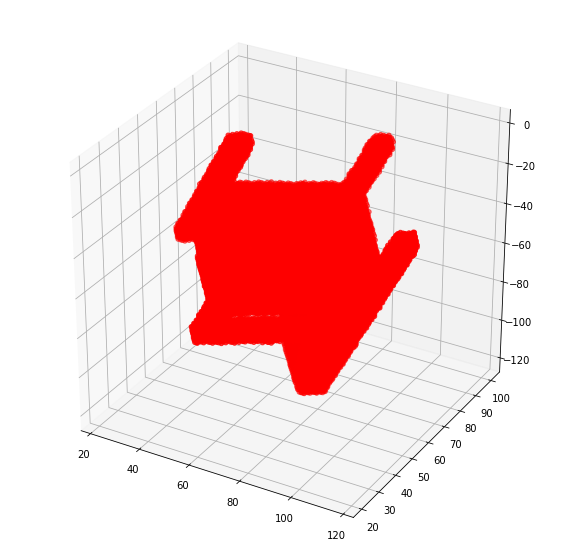

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

z,x,y = temp.nonzero()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c = 'red')
#ax.view_init(azim=-45)
plt.show()


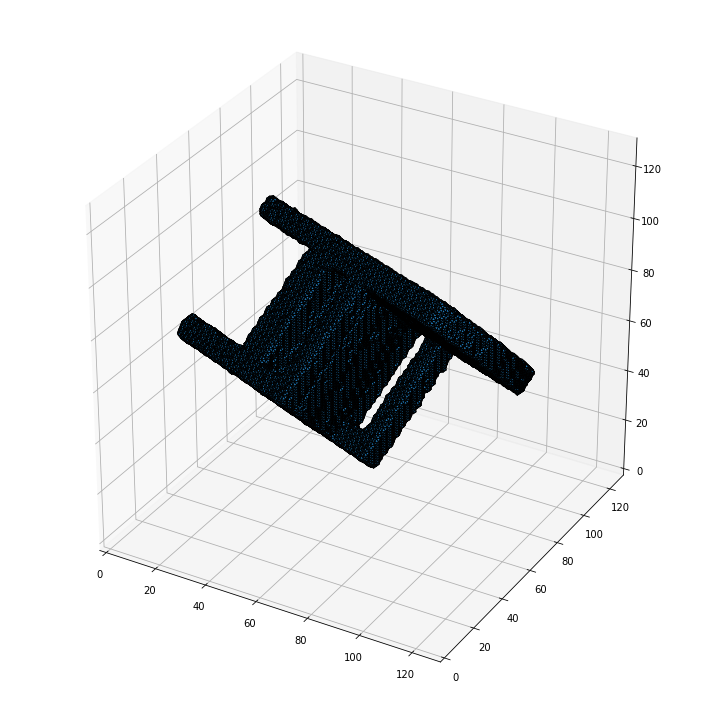

(34778, 3)


In [91]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid
verts, faces, normals, values = measure.marching_cubes_lewiner(temp, 0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh111 = Poly3DCollection(verts[faces])
mesh111.set_edgecolor('k')
ax.add_collection3d(mesh111)

ax.set_xlim(0, 128) 
ax.set_ylim(0, 128)  
ax.set_zlim(0, 128)  
#ax.view_init(azim=-45)
plt.tight_layout()
plt.show()
print(verts.shape)

In [79]:
label = np.load("C:/Arpit/shapenet_cars_chairs_planes_20views/Chair/1a8bbf2994788e2743e99e0cae970928/03001627_1a8bbf2994788e2743e99e0cae970928_view000_gt_rotvox_samescale_128.npz") 
label = label['voxel']

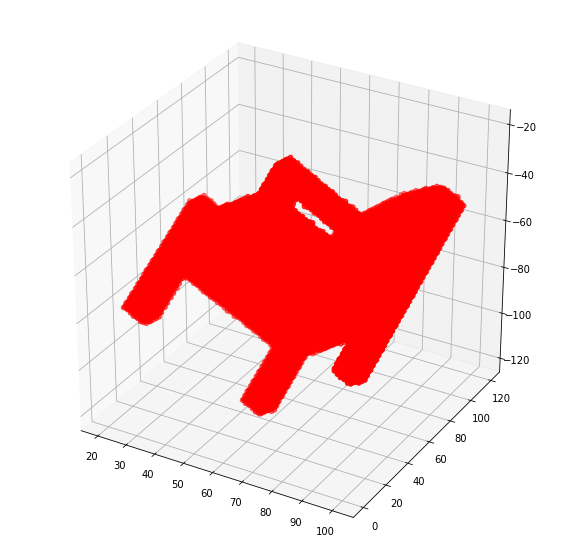

97437 97437 97437


In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

z,x,y = label.nonzero()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red')
#ax.view_init(azim=-180)
plt.show()
print(len(z),len(x),len(y))
